In [1]:
from casadi import *
from numpy import *
import matplotlib.pyplot as plt

In [2]:
N = 200 # number of control intervals

M = 5.0
m = 0.5
L = 1.0
g = 9.8

# Damping factor
D = 0.02


opti = Opti() # Optimization problem

# ---- decision variables ---------
X = opti.variable(4,N+1) # state trajectory x, xD, theta, thetaD
x = X[0,:]
xD = X[1,:]
theta = X[2,:]
thetaD = X[3,:]

U = opti.variable(1,N)   # control trajectory (accleration, phi_dot)
force = U[0,:]

T = 20      # Total time

# ---- dynamic constraints --------

def f(x, u):
    # x = [x, xD, theta, thetaD]
    xDD = ( 1 / (M+m*np.sin(x[2])**2) ) * ( u + m*np.sin(x[2]) * (L*x[3]**2 + g*np.cos(x[2])) )
    tDD = ( 1 / (L * (M+m*np.sin(x[2])**2)) ) * ( -u*np.cos(x[2]) - m*L*(x[3]**2)*np.cos(x[2])*np.sin(x[2]) - (M+m)*g*np.sin(x[2]) )
    return vertcat(x[1]+xDD*(dt+D),xDD, x[3]+tDD*(dt+D), tDD)

dt = T/N # length of a control interval
for k in range(N): # loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
    opti.subject_to(X[:,k+1]==x_next) # close the gaps

# ---- constraints -----------
# # State limits
# opti.subject_to(opti.bounded(-7.75, v, 77.75))   # track speed limit
# opti.subject_to(opti.bounded(-0.58206731, phi, 0.58206731))   # steering angle limit
# Control limits
opti.subject_to(opti.bounded(-50.0, force, 50.0))   # force limit
opti.subject_to(opti.bounded(-2.5, x, 2.5))

# ---- Initial conditions --------
opti.subject_to(x[0]==0)   # start at position 0 ...
opti.subject_to(theta[0]==0)   # start at position 0 ...
opti.subject_to(xD[0]==0) # ... from stand-still 
opti.subject_to(thetaD[0]==0)

# Final Conditions
opti.subject_to((theta[50:]-np.pi)**2 <= 0.08)
# opti.subject_to(thetaD[-1]==0)

# ---- initial values for solver ---
opti.set_initial(force, 50.0)
# opti.set_initial(phi, 0.0)
# opti.set_initial(T, 1)

# ----         objective          ---------
# Weight matrices
Q = np.eye(N+1)
R = 0.08 * np.eye(N)

# Loss function definition
opti.minimize( cos(theta)@Q@cos(theta).T + force@R@force.T )

# ---- solve NLP              ------
opti.solver("ipopt") # set numerical backend
sol = opti.solve()   # actual solve


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3804
Number of nonzeros in inequality constraint Jacobian.:      552
Number of nonzeros in Lagrangian Hessian.............:    41201

Total number of variables............................:     1004
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

<IPython.core.display.Javascript object>


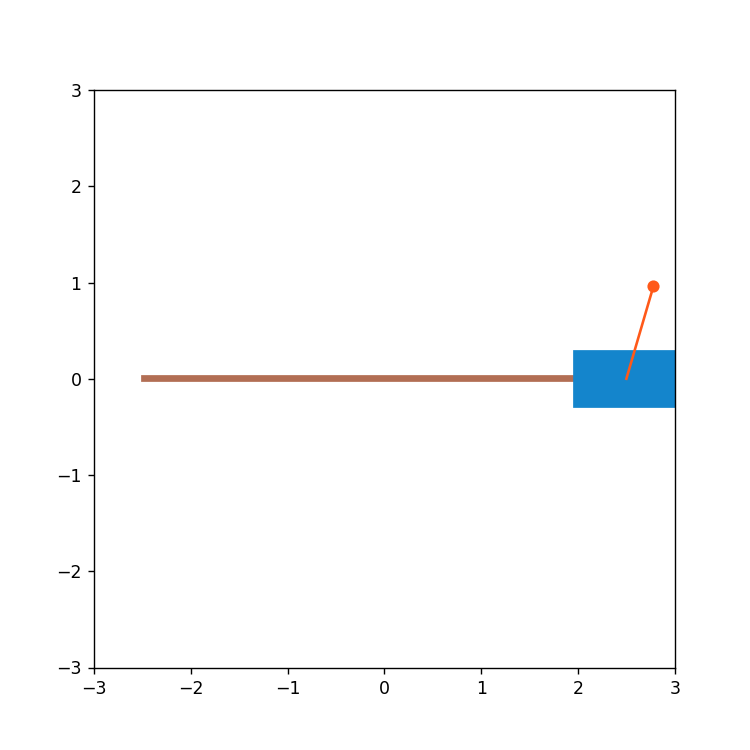

In [3]:
# Plotting Live
%matplotlib notebook
import matplotlib.patches as patches

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

# Origin
orig_y = 0.0
bsizex = (M/3)*0.65
bsizey = (M/3)*0.35

x = sol.value(x)
theta = sol.value(theta)

for i in range(0, x.shape[0]):
    
    ax.clear()
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    
    # Getting new positions
    cx = x[i]
    cy = orig_y
    
    rect = patches.Rectangle((cx-bsizex/2,cy-bsizey/2),bsizex,bsizey,linewidth=1,color='#1485CC',fill=True)
    line = patches.Rectangle((-2.5,-0.025),5,0.05,linewidth=1,color='#B26E54',fill=True)
    
    px = cx + L*np.sin(theta[i])
    py = cy - L*np.cos(theta[i])
    
    # Plotting the latest position
    ax.add_patch(line)
    ax.plot([cx, px], [cy, py], color='#FF5919')
    ax.add_patch(rect)
    ax.scatter(px, py, color='#FF5919')
    fig.canvas.draw()
    
    plt.pause(dt/2)
    
plt.show()